In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.rijke_esn import RijkeESN
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils.enums import eParam, get_eVar
import adjoint_esn.visualize_rijke_esn as vis_rijke
from pathlib import Path
from adjoint_esn.rijke_galerkin.solver import Rijke
from scipy.integrate import odeint
from adjoint_esn.utils import signals as sig
import adjoint_esn.utils.visualizations as vis
from adjoint_esn.utils import errors,scalers
from scipy import signal
from functools import partial
from adjoint_esn.utils.discretizations import finite_differences

## Data generation

In [2]:
# number of galerkin modes
N_g = 4

# simulation options
sim_time = 800
sim_dt = 1e-3

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('..\data')

# which regimes to use for training and validation
INIT_beta_list = np.arange(1.0,6.0,1.0)
INIT_tau_list = [0.2]
train_param_list = pp.make_param_mesh([INIT_beta_list,INIT_tau_list])

train_idx_list=np.arange(len(train_param_list))
val_idx_list=np.arange(len(train_param_list))

transient_time = 200

# network time step
network_dt = 1e-2

washout_time = 4

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars ='eta_mu'
eInputVar = get_eVar(input_vars,N_g)
output_vars ='eta_mu'
eOutputVar = get_eVar(output_vars,N_g)

# which system parameter is passed to the ESN
param_vars=['beta']

# if using Rijke ESN what is the order of u_f(t-tau) in the inputs,
# [u_f(t-tau), u_f(t-tau)^2 ..., u_f(t-tau)^(u_f_order)]
u_f_order = 1


# length of training time series
train_time = 256
# length of validation time series
validation_time = 200
# can add test, then add it in the loop_names and loop_times
test_time = 10

loop_names=['train','val']
loop_times = [train_time,validation_time]

DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(train_param_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        loop_names=loop_names,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]

### Plot data

In [ ]:
len_p_list=len(train_param_list)
plt_idx = [eInputVar.eta_1,eInputVar.eta_2,eInputVar.mu_1,eInputVar.mu_2,eInputVar.v_tau]
for p_idx in range(len_p_list):
    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_lines(DATA["train"]["t"][p_idx],DATA["train"]["u"][p_idx][:,k],
                   title=f"beta = {train_param_list[p_idx][eParam.beta]}, tau = {train_param_list[p_idx][eParam.tau]},",
                   xlabel='t',
                   ylabel=k.name)
        plt.xlim([4,24])

## Run hyperparameter search

In [3]:
from adjoint_esn.validation import validate as validate_v2

# hyperparameter names, should match the attributes of ESN
hyp_param_names = ['input_scaling','spectral_radius','leak_factor','parameter_normalization_mean','parameter_normalization_var','tikhonov']

# range for hyperparameters 
spec_in     = 0.01
spec_end    = 1.0
in_scal_in  = 0.05
in_scal_end = 5.0
u_f_scal_in  = 1.0
u_f_scal_end = 2.0
leak_in     = 0.1    
leak_end    = 1.0
param_var_in = 1.0 
param_var_end = 10.0
param_mean_in = -10.0
param_mean_end = 10.0
tikh_in = 1e-3
tikh_end = 1
grid_range = [[in_scal_in, in_scal_end],
              [spec_in, spec_end],
              [leak_in, leak_end],
              [param_mean_in, param_mean_end],
              [param_var_in, param_var_end],
              [tikh_in, tikh_end]]

# scales, uniform or log10
hyp_param_scales = ['log10','log10','uniform','uniform','uniform','log10']

# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, hyp_param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])
        
N_washout = int(np.round(washout_time/network_dt))
fold_time = 4
N_val = int(np.round(fold_time/network_dt))
N_transient = 0
reservoir_size = 300
connectivity = 3
ESN_dict = {'reservoir_size': reservoir_size, 
            'dimension' : dim, 
            # 'N_g' : N_g,
            # 'x_f' : 0.2,
            # 'tau' : 0.2,
            # 'dt' : 0.01,
            # 'u_f_order': u_f_order,
            'parameter_dimension' : len(param_vars),
            'reservoir_connectivity' : connectivity,
            'input_normalization': None, 
            'input_bias' : np.array([]),
            'output_bias' : np.array([]),
            'parameter_normalization': [np.array([0.0]),np.array([1.0])],
            'r2_mode': False,
            'input_weights_mode': "sparse_grouped",
            'reservoir_weights_mode': "erdos_renyi2",
            'input_only_mode': False,
            'tikhonov': 1e-1,
            }
min_dict = validate_v2(grid_range,hyp_param_names,hyp_param_scales,
    n_calls = 2, n_initial_points = 1,
    ESN_dict = ESN_dict, ESN_type = "standard",
    U_washout_train = DATA["train"]["u_washout"],
    U_train = DATA["train"]["u"],
    U_val = DATA["val"]["u"],
    Y_train = DATA["train"]["y"],
    Y_val = DATA["val"]["y"],
    P_washout_train = DATA["train"]["p_washout"],
    P_train = DATA["train"]["p"],
    P_val = DATA["val"]["p"],
    n_folds = 4,
    n_realisations=3,
    N_washout_steps = N_washout,
    N_val_steps = N_val,
    N_transient_steps = N_transient,
    train_idx_list=train_idx_list,
    val_idx_list=val_idx_list,
    p_list=train_param_list,
    n_grid = None)

--NEW RUN-- 1
Realisation: 0
input_scaling 0.19792119666338973
spectral_radius 0.09753935043347353
leak_factor 0.49871345291974767
parameter_normalization_mean 6.638227179424025
parameter_normalization_var 6.249895632439627
tikhonov 0.001


Val regime: 0
Val regime error: 3.703385867954179
Val regime: 1
Val regime error: 16.61926428713229
Val regime: 2
Val regime error: 13.89692401901455
Val regime: 3
Val regime error: 16.576817379018898
Val regime: 4
Val regime error: 11.613373011084217
Realisation error: 62.40976456420414


Realisation: 1
input_scaling 0.19792119666338973
spectral_radius 0.09753935043347353
leak_factor 0.49871345291974767
parameter_normalization_mean 6.638227179424025
parameter_normalization_var 6.249895632439627
tikhonov 0.001


Val regime: 0
Val regime error: 0.041565180103618135
Val regime: 1
Val regime error: 10.392051826099305
Val regime: 2
Val regime error: 18.44741146512273
Val regime: 3
Val regime error: 16.054176652597338
Val regime: 4
Val regime error: 14.6

## Train ESN

In [ ]:
print('System dimension: ', dim)
res_idx = 0
my_ESN = ESN(reservoir_size = ESN_dict["reservoir_size"], 
            dimension = dim, 
            parameter_dimension = 1, 
            reservoir_connectivity = ESN_dict["reservoir_connectivity"], 
            spectral_radius = min_dict["spectral_radius"][res_idx],                            
            input_scaling = min_dict["input_scaling"][res_idx],
            leak_factor = min_dict["leak_factor"][res_idx],
            parameter_normalization=[np.array([min_dict["parameter_normalization_mean"][res_idx]]),
                                    np.array([min_dict["parameter_normalization_var"][res_idx]])],
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = None, 
            r2_mode=False,
            input_weights_mode='sparse_grouped',
            reservoir_weights_mode='erdos_renyi2',
            input_only_mode=False,
            input_seeds=[None,None,None],
            reservoir_seeds=[None,None],
            tikhonov= min_dict["tikhonov"][res_idx],
            verbose=False)

In [ ]:
print('System dimension: ', dim)
res_idx = 0
my_ESN = RijkeESN(reservoir_size = ESN_dict["reservoir_size"], 
            N_g = N_g,
            u_f_order = u_f_order,
            x_f = 0.2,
            tau = 0.2,
            dt = network_dt,
            parameter_dimension = 1, 
            reservoir_connectivity =  ESN_dict["reservoir_connectivity"],   
            input_scaling = min_dict["input_scaling"][res_idx],                             
            u_f_scaling= min_dict["u_f_scaling"][res_idx],
            leak_factor = min_dict["leak_factor"][res_idx],
            parameter_normalization=[np.array([min_dict["parameter_normalization_mean"][res_idx]]),
                                     np.array([min_dict["parameter_normalization_var"][res_idx]])],
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = None, 
            r2_mode=False,
            input_only_mode=True,
            input_weights_mode="sparse_grouped_rijke_dense",
            input_seeds=[0,1,2],
            reservoir_seeds=[3,4],
            tikhonov= min_dict["tikhonov"][res_idx]
            )

In [57]:
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

## Visualize the blocks of ESN

In [ ]:
vis_rijke.visualize_heat_release(my_ESN)
vis_rijke.visualize_acoustics(my_ESN)

## Test ESN

Regime: beta = 1.0, tau = 0.2, Error: 2.2682500288824823
Regime: beta = 1.5, tau = 0.2, Error: 1.9577931812117142
Regime: beta = 2.0, tau = 0.2, Error: 1.6539803532057527
Regime: beta = 2.5, tau = 0.2, Error: 1.2341473669144927
Regime: beta = 3.0, tau = 0.2, Error: 0.8225438067698015
Regime: beta = 3.5, tau = 0.2, Error: 1.1646900709189105
Regime: beta = 4.0, tau = 0.2, Error: 0.7775430540955701
Regime: beta = 4.5, tau = 0.2, Error: 0.08294584913381556


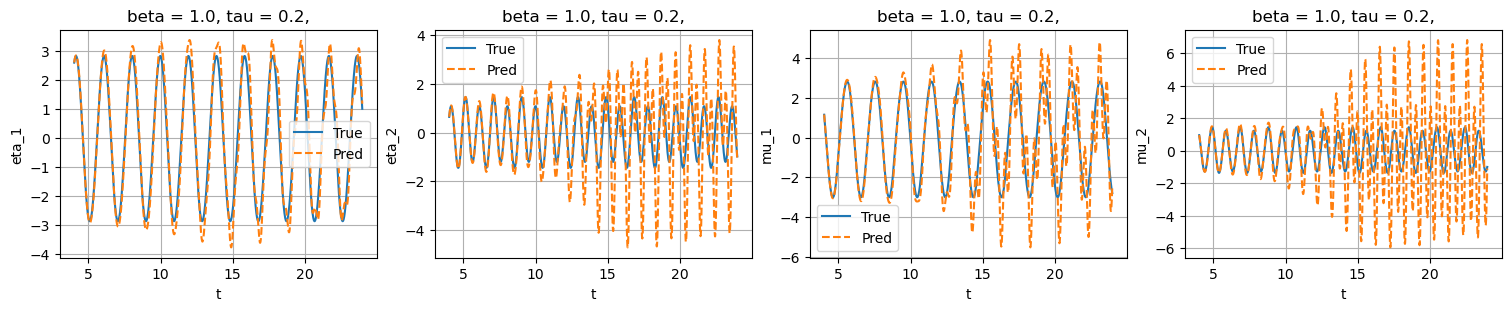

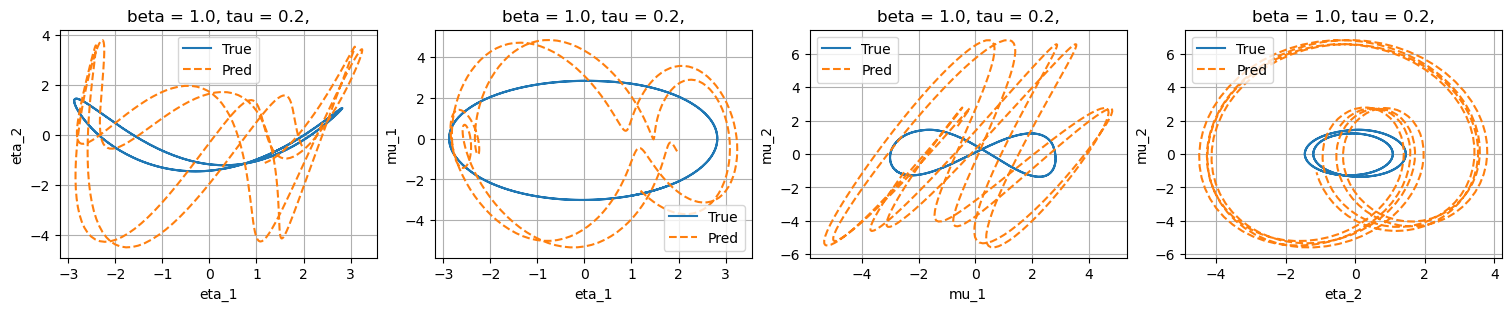

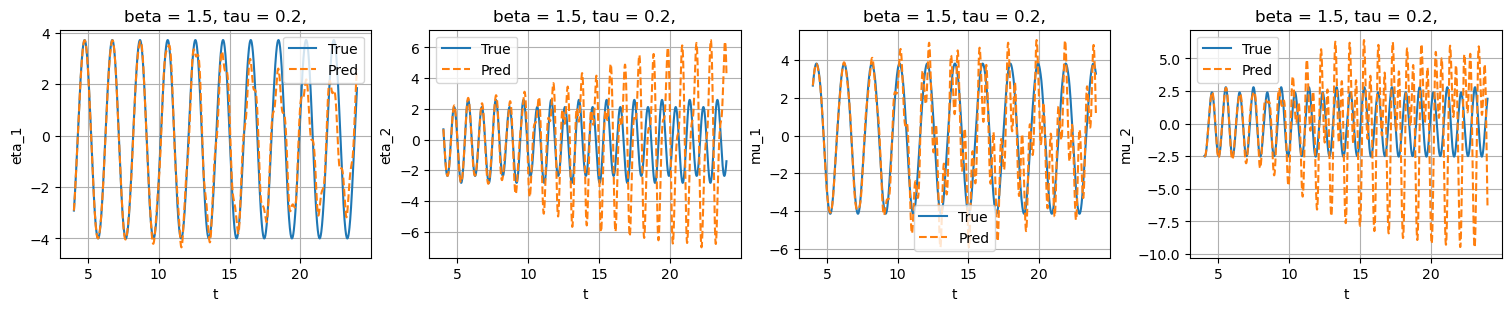

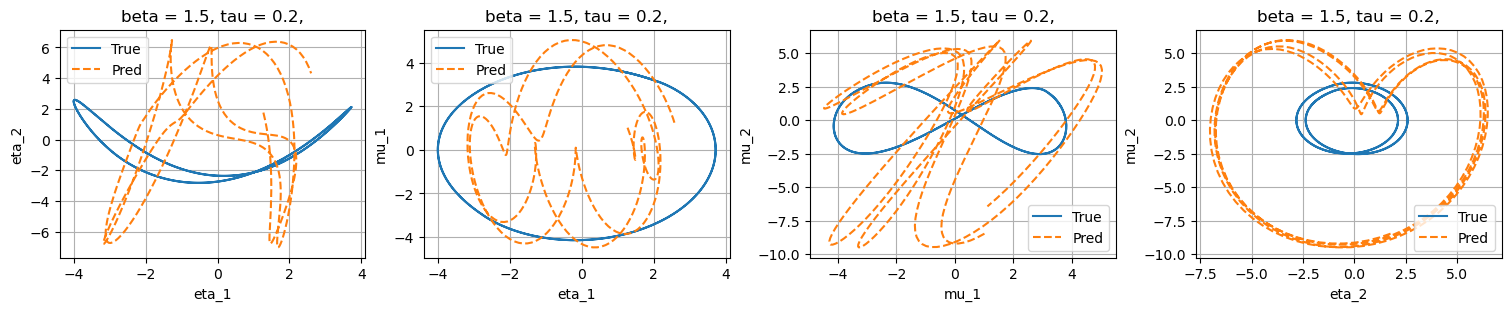

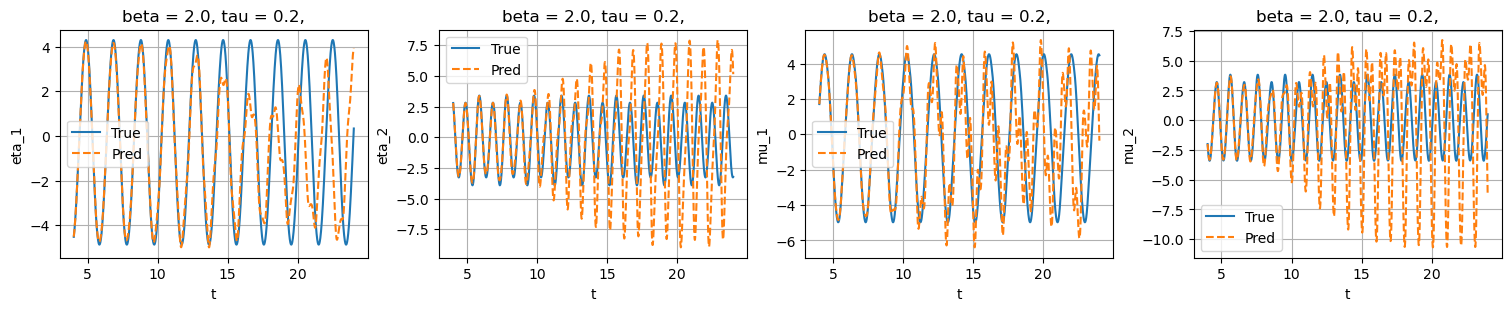

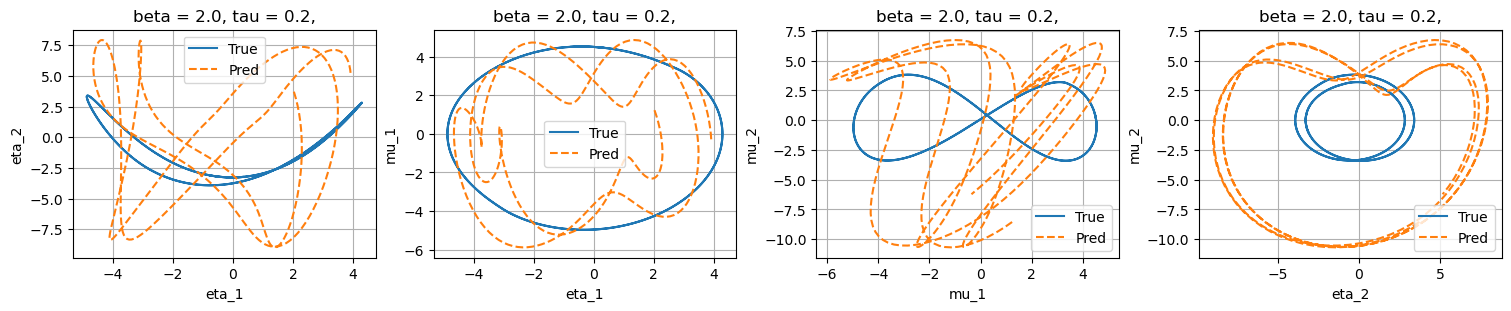

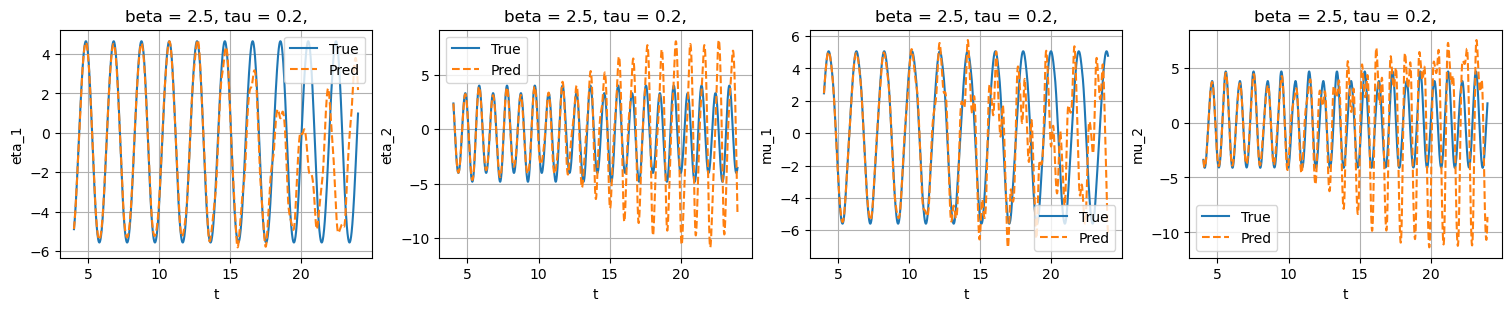

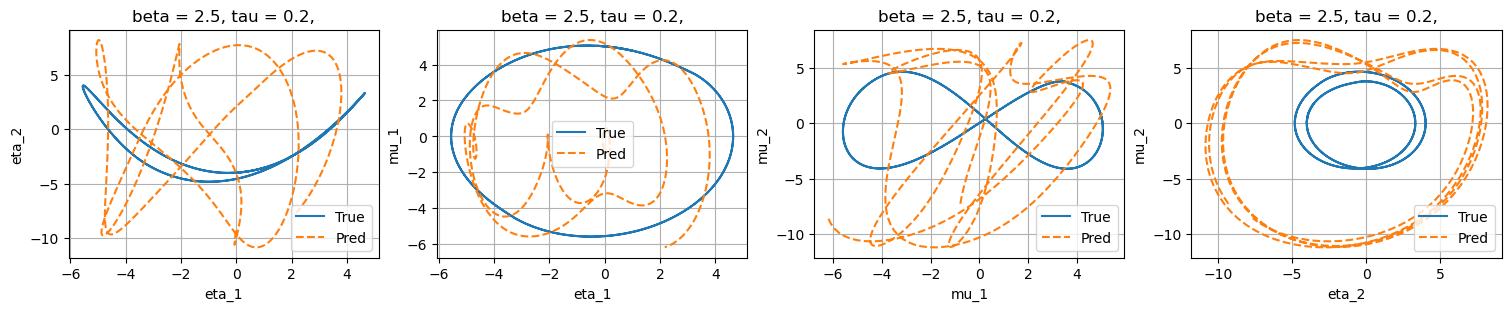

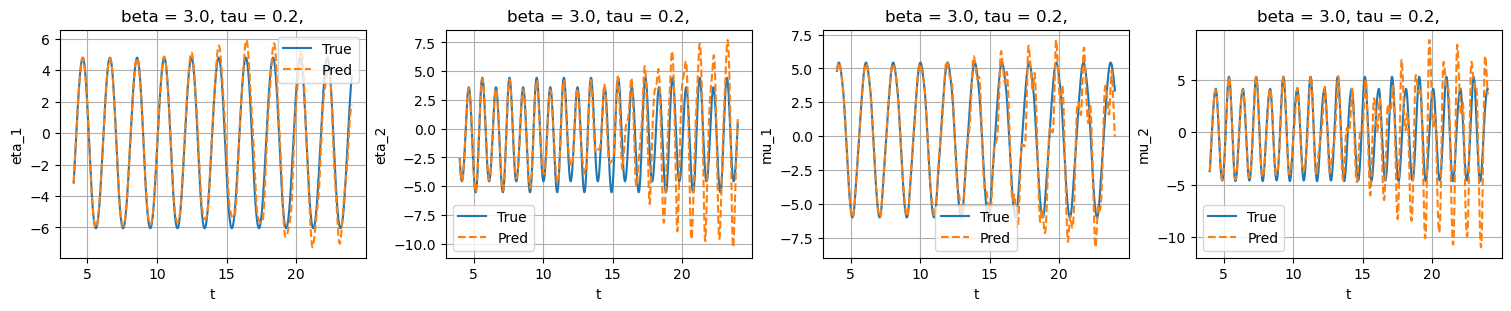

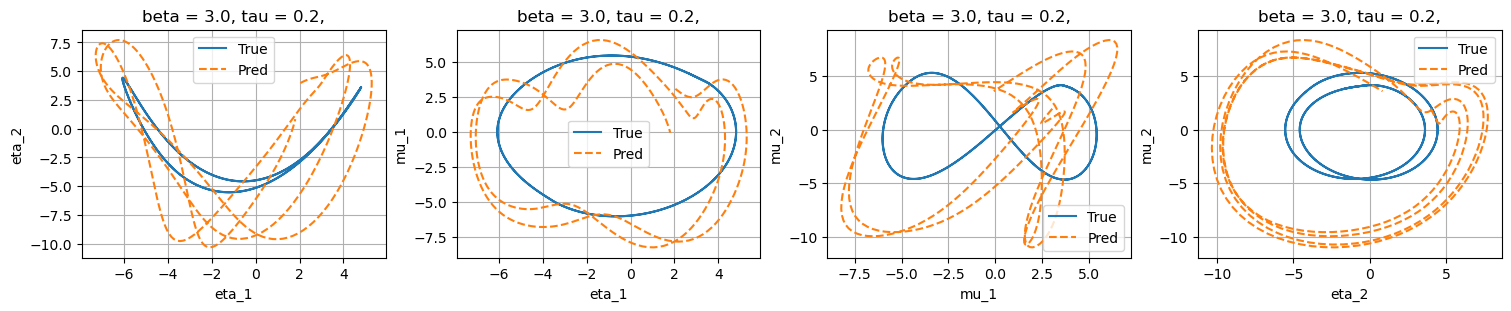

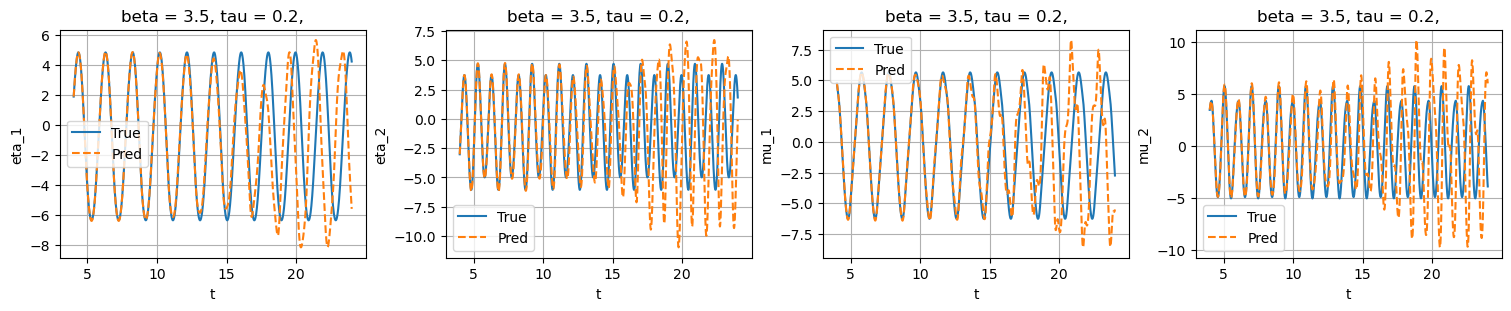

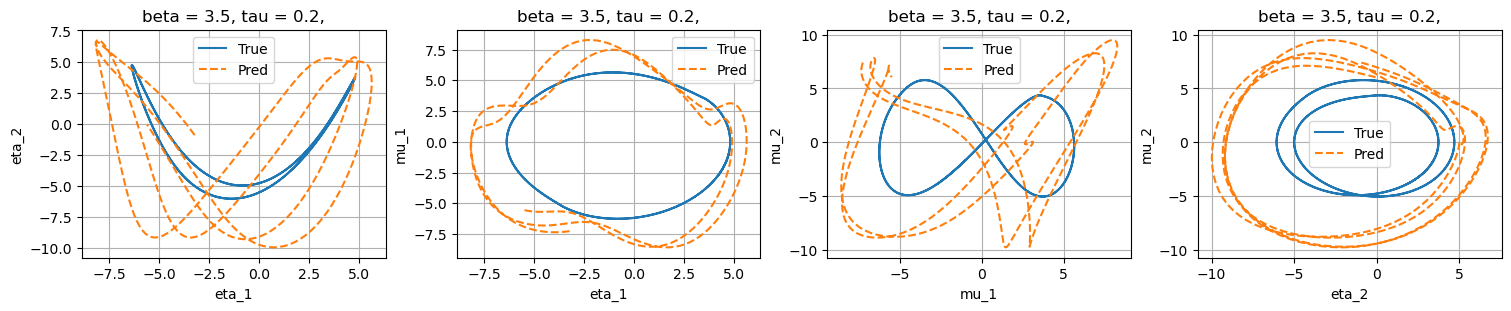

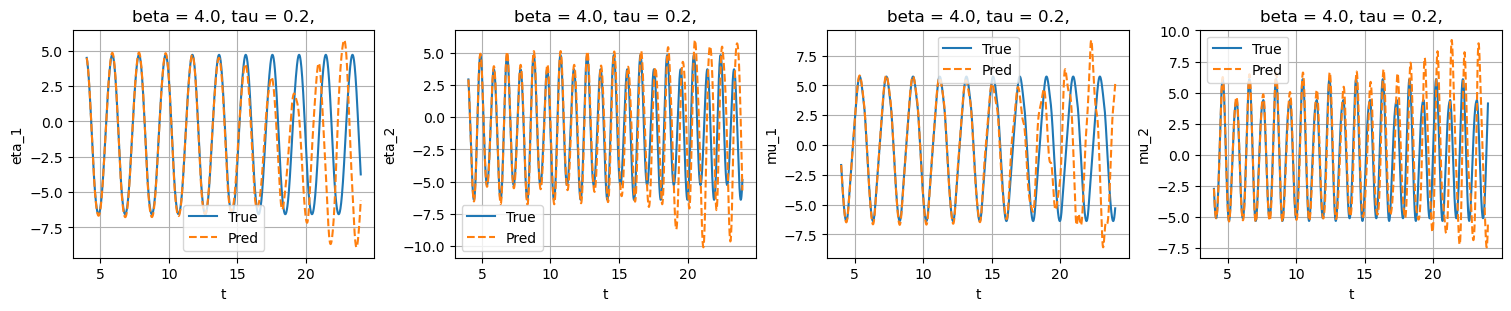

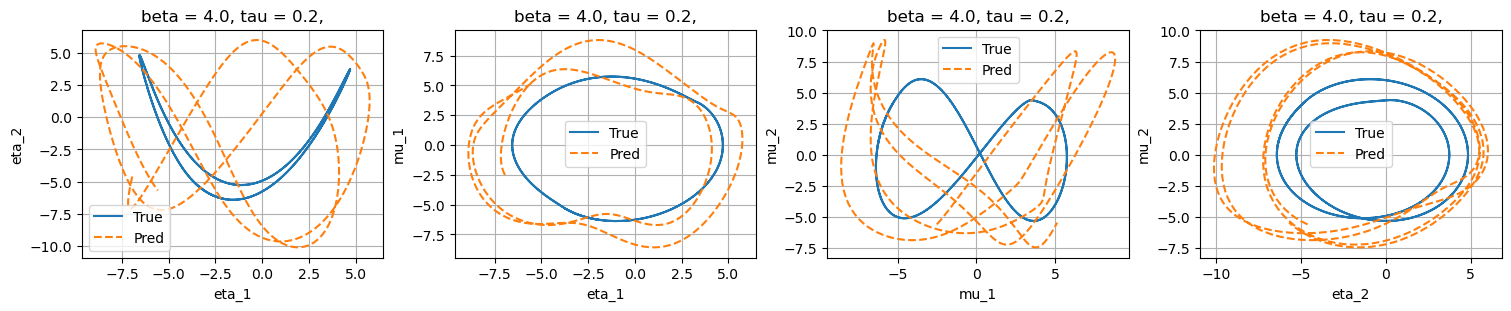

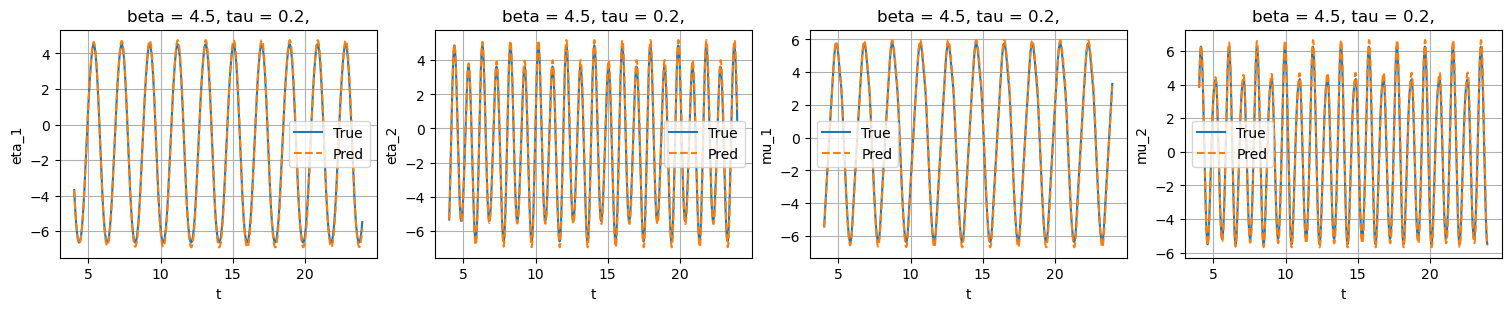

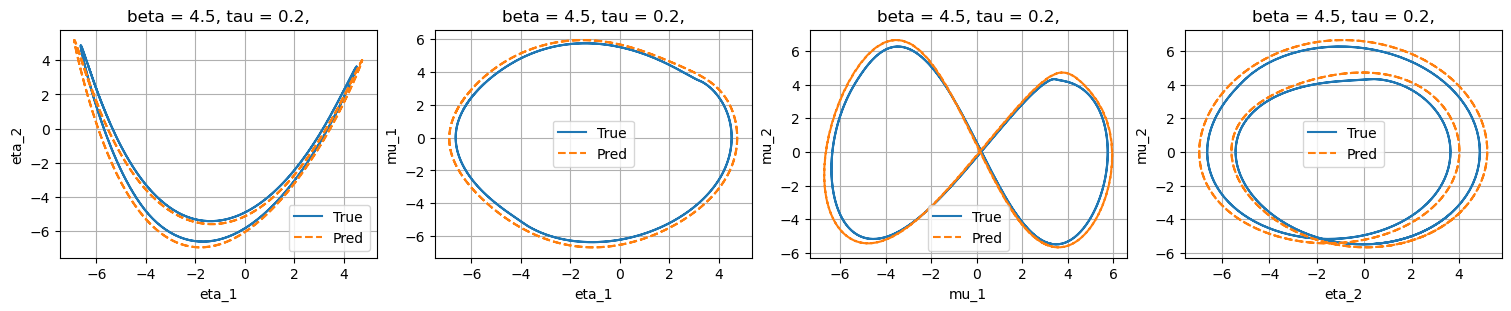

In [58]:
sim_time = 300
loop_times = [20]
beta_list = np.arange(1.0,5.0,0.5)
tau_list = [0.2]
plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]
plt_idx_pairs = [[eOutputVar.eta_1,eOutputVar.eta_2],
                 [eOutputVar.eta_1,eOutputVar.mu_1],
                 [eOutputVar.mu_1,eOutputVar.mu_2],
                 [eOutputVar.eta_2,eOutputVar.mu_2]]
phase_space_steps = pp.get_steps(4,network_dt)

error_measure = errors.rel_L2
p_list = pp.make_param_mesh([beta_list,tau_list])

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]
        regime_str = f"beta = {p_list[p_idx][eParam.beta]}, tau = {p_list[p_idx][eParam.tau]},"

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_lines(data[loop_name]["t"],data[loop_name]["y"][:,k],y_pred[:,k],
                       title=regime_str,
                       xlabel='t',
                       ylabel=k.name,
                       linestyle=['-','--'],
                       legend=['True','Pred'])
            
        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             title=regime_str,
                             linestyle=['-','--'],
                             legend=['True','Pred'])
            plt.xlabel(k[0].name)
            plt.ylabel(k[1].name)

        print('Regime:',regime_str,'Error:', error_measure(data[loop_name]["y"],y_pred))

## Statistics

In [ ]:
sim_time = 500
loop_times = [200]

beta_list = np.arange(5.5,7.5,0.5)
tau_list = [0.2]
p_list = pp.make_param_mesh([beta_list,tau_list])

plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]
        regime_str = f"beta = {p_list[p_idx][eParam.beta]}, tau = {p_list[p_idx][eParam.tau]},"

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_statistics(data[loop_name]["y"][:,k],y_pred[:,k],
                                title=regime_str,
                                xlabel=k.name,
                                ylabel='PDF',
                                linestyle=['-','--'],
                                legend=['True','Pred'])

## Bifurcation diagram

In [ ]:
sim_time = 300
loop_times = [100]

beta_list = [3.0]
tau_list = np.arange(0.1,0.4,0.1)

if len(beta_list) > 1 and len(tau_list) == 1:
    vary_param = 'beta'
elif len(beta_list) == 1 and len(tau_list) > 1:
    vary_param = 'tau'
else:
    raise ValueError("For this plot one parameter needs to be varying and the other fixed.")
p_list = pp.make_param_mesh([beta_list,tau_list])

vary_param_train = list(set(train_param_list[train_idx_list,eParam[vary_param]]))

plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]

fig, ax = plt.subplots(nrows=2, 
                        ncols=len(plt_idx), 
                        figsize=(15,5), 
                        constrained_layout=True)

# track minimum and maximum values of the peaks 
pks_min = np.inf*np.ones((len(p_list),len(plt_idx)))   
pks_max = -np.inf*np.ones((len(p_list),len(plt_idx)))   

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    
    _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                N_t=len(data[loop_name]["u"]), 
                                                P_washout=data[loop_name]["p_washout"],  
                                                P=data[loop_name]["p"])
    y_pred = y_pred[1:]

    for j, k in enumerate(plt_idx):
        plt.sca(ax[0,j])
        pks_true = vis.plot_bifurcation_diagram(p_sim[vary_param], data[loop_name]["y"][:,k], 
                                        color='tab:blue', 
                                        marker='*', 
                                        linestyle='None')
        min_pks_true = np.min(pks_true)
        max_pks_true = np.max(pks_true)

        plt.sca(ax[1,j])
        pks_pred = vis.plot_bifurcation_diagram(p_sim[vary_param], y_pred[:,k],
                                        color='tab:orange', 
                                        marker='*', 
                                        linestyle='None')
        min_pks_pred = np.min(pks_pred)
        max_pks_pred = np.max(pks_pred)

        pks_min[p_idx,j] = min(pks_min[p_idx,j], min(min_pks_true,min_pks_pred))
        pks_max[p_idx,j] = max(pks_max[p_idx,j], max(max_pks_true,max_pks_pred))

for j, k in enumerate(plt_idx):
    for i in range(ax.shape[0]):
        ylims = [np.min(pks_min[:,j]),np.max(pks_max[:,j])]
        ax[i,j].set_ylim(ylims)
        ax[i,j].set_xlabel(vary_param)
        ax[i,j].set_ylabel(f"Local maxima of {k.name}")
        ax[i,j].vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')
        ax[i,j].grid()

## Hopf bifurcation curve

In [ ]:
def acoustic_energy(y, N_g):
    return 1/4*np.mean(np.sum(y[:,:2*N_g]**2, axis = 1))

In [ ]:
sim_time = 300
loop_times = [100]

beta_list = np.arange(0.5,2.5,0.5)
tau_list = np.arange(0.1,0.4,0.1)

def energy_decreased(y, N_g, percent_threshold = 5):
    half_steps = int(np.round(len(y)/2))
    e1 = acoustic_energy(y[:half_steps],N_g)
    e2 = acoustic_energy(y[half_steps:],N_g)
    return e1-e2 > (percent_threshold/100)*e1

percent_threshold = 5
p_energy_decreased = partial(energy_decreased, N_g=N_g, percent_threshold=percent_threshold)
bifn_point_true = np.zeros(len(tau_list))
bifn_point_pred = np.zeros(len(tau_list))

for tau_idx, tau in enumerate(tau_list):
    for beta_idx, beta in enumerate(beta_list): 
        p_sim = {'beta':beta, 'tau':tau}
        y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                    sim_time=sim_time,sim_dt=sim_dt,
                                    data_dir=data_dir)

        data = pp.create_dataset(y_sim,t_sim,p_sim,
                            network_dt=network_dt,
                            transient_time=transient_time,
                            washout_time=washout_time,
                            loop_times=loop_times,
                            input_vars=input_vars,
                            output_vars=output_vars,
                            param_vars=param_vars,
                            N_g=N_g,
                            u_f_order=u_f_order)
        
        loop_name = list(data.keys())[0]

        if hasattr(my_ESN,"tau"):
            my_ESN.tau = p_sim["tau"]
        
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]

        if p_energy_decreased(data[loop_name]["y"]):
            bifn_point_true[tau_idx] = beta

        if p_energy_decreased(y_pred):
            bifn_point_pred[tau_idx] = beta

        if not p_energy_decreased(data[loop_name]["y"]) and not p_energy_decreased(y_pred):
            break
        
plt.figure(figsize=(5,5))
vis.plot_reverse_lines(bifn_point_true,bifn_point_pred,y=tau_list,
                       linestyle=['-','--'],
                       xlabel='beta',
                       ylabel='tau')

## Sensitivity

In [ ]:
def true_direct_sensitivity(my_rijke, t_bar, y_bar):
    dt = t_bar[1]-t_bar[0]
    # direct problem
    dir0 = np.zeros(2*my_rijke.N_dim+2)
    dir = odeint(my_rijke.direct_ode,dir0,t_bar,args=(t_bar,1/dt,y_bar),tfirst= True)
    dJdp = 1/t_bar[-1]*dir[-1,-2]
    return dJdp

def true_adjoint_sensitivity(my_rijke, t_bar, y_bar):
    dt = t_bar[1]-t_bar[0]
    # adjoint problem
    adjT = np.zeros(my_rijke.N_dim+2)
    adj = odeint(my_rijke.adjoint_ode,adjT,np.flip(t_bar),args =(t_bar,1/dt,y_bar),tfirst= True)
    dJdp  = 1/t_bar[-1]*adj[-1,-2:]
    return dJdp

def true_finite_difference_sensitivity(my_rijke, t_bar, y_bar, h, h_tau, method):
    # Calculate numerically
    # Find perturbed solutions (in beta)
    dJdp = np.zeros((2,))

    # left solution with beta = beta-h
    my_rijke_beta_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta-h,x_f=my_rijke.x_f,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_beta_left = odeint(my_rijke_beta_left.ode,y_bar[0,:],t_bar,tfirst = True)
    J_beta_left = acoustic_energy(y_bar_beta_left[1:,:], my_rijke.N_g)
        
    # right solution with beta = beta+h
    my_rijke_beta_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta+h,x_f=my_rijke.x_f,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_beta_right = odeint(my_rijke_beta_right.ode,y_bar[0,:],t_bar,tfirst = True)
    J_beta_right = acoustic_energy(y_bar_beta_right[1:,:], my_rijke.N_g)

    # left solution with tau = tau-h
    my_rijke_tau_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau-h_tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_tau_left = odeint(my_rijke_tau_left.ode,y_bar[0,:],t_bar,tfirst = True)
    J_tau_left = acoustic_energy(y_bar_tau_left[1:,:], my_rijke.N_g)
        
    # # right solution with tau = tau+h
    my_rijke_tau_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau+h_tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_tau_right = odeint(my_rijke_tau_right.ode,y_bar[0,:],t_bar,tfirst = True)
    J_tau_right = acoustic_energy(y_bar_tau_right[1:,:], my_rijke.N_g)

    # define which finite difference method to use
    finite_difference = partial(finite_differences, method=method)

    J = acoustic_energy(y_bar[1:,:],my_rijke.N_g)
    dJdp[eParam.beta] = finite_difference(J, J_beta_right, J_beta_left, h)
    dJdp[eParam.tau] = finite_difference(J, J_tau_right, J_tau_left, h_tau)
    return dJdp


In [ ]:
sim_time = 310
loop_times = [100]

beta_list = np.arange(0.5,5.7,0.2)
tau_list = [0.2]

if len(beta_list) > 1 and len(tau_list) == 1:
    vary_param = 'beta'
elif len(beta_list) == 1 and len(tau_list) > 1:
    vary_param = 'tau'
else:
    raise ValueError("For this plot one parameter needs to be varying and the other fixed.")
p_list = pp.make_param_mesh([beta_list,tau_list])

vary_param_train = list(set(train_param_list[train_idx_list,eParam[vary_param]]))

finite_difference_method = 'central'
methods = ['numerical']
dJdp = {'true':{},'esn':{}}
for method_name in methods:
    dJdp['true'][method_name] = np.zeros((len(p_list),2))
    if not hasattr(my_ESN,"tau"): 
        dJdp['esn'][method_name] = np.zeros((len(p_list),len(param_vars)))
    else:
        dJdp['esn'][method_name] = np.zeros((len(p_list),2))

J = {'true':np.zeros(len(p_list)),'esn':np.zeros(len(p_list))}

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    print('Regime:',regime_str)
    
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    N_transient = pp.get_steps(transient_time,sim_dt)
    y_bar = y_sim[N_transient:,:]
    t_bar = t_sim[N_transient:]

    N_washout = pp.get_steps(washout_time,sim_dt)
    N_loop = pp.get_steps(loop_times[0],sim_dt)+1
    y_bar = y_bar[N_washout:N_washout + N_loop,:]
    t_bar = t_bar[N_washout:N_washout + N_loop]-t_bar[N_washout]

    my_rijke = Rijke(
            N_g=N_g,
            N_c=10,
            c_1=0.1,
            c_2=0.06,
            beta=p_sim["beta"],
            x_f=0.2,
            tau=p_sim["tau"],
            heat_law="kings_poly",
            damping="modal",
        )
    # NOTE: because of downsampling, e.g. sim_dt = 1e-3, network_dt = 1e-2, y_bar[10] = data[loop_name]["y"][0]
    # how much does this, and downsampling overall, affect the accuracy?
    J["true"][p_idx] = acoustic_energy(y_bar[1:,:], N_g)
    for method_name in methods:
        if method_name == "direct":
            dJdp["true"][method_name][p_idx]= true_direct_sensitivity(my_rijke, t_bar, y_bar)
        elif method_name == "adjoint":
            dJdp["true"][method_name][p_idx]= true_adjoint_sensitivity(my_rijke, t_bar, y_bar)
        elif method_name == "numerical":
            dJdp["true"][method_name][p_idx]= true_finite_difference_sensitivity(my_rijke, t_bar, 
                                                                                 y_bar, 
                                                                                 h=1e-5, 
                                                                                 h_tau=network_dt, 
                                                                                 method=finite_difference_method)
        print(f'True dJ/dp, {method_name} = {dJdp["true"][method_name][p_idx]}')

    # Wash-out phase to get rid of the effects of reservoir states initialised as zero
    # initialise the reservoir states before washout
    x0_washout = np.zeros(my_ESN.N_reservoir)

    N = len(data[loop_name]["u"])

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    
        # let the ESN run in open-loop for the wash-out
        # get the initial reservoir to start the actual open/closed-loop,
        # which is the last reservoir state
        X_tau = my_ESN.open_loop(x0=x0_washout, U=data[loop_name]["u_washout"], P=data[loop_name]["p_washout"])
        P_grad = np.vstack((data[loop_name]["p_washout"][-my_ESN.N_tau - 1 :, :], data[loop_name]["p"]))
        X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N, P=P_grad)
        for method_name in methods:
            if method_name == "direct":
                dJdp["esn"][method_name][p_idx]= my_ESN.direct_sensitivity(X_pred_grad, Y_pred_grad, N, X_tau)
            elif method_name == "adjoint":
                dJdp["esn"][method_name][p_idx]= my_ESN.adjoint_sensitivity(X_pred_grad, Y_pred_grad, N, X_tau)
            elif method_name == "numerical":
                dJdp["esn"][method_name][p_idx]= my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                                                                                Y_pred_grad, 
                                                                                                X_tau, 
                                                                                                P_grad, 
                                                                                                N, 
                                                                                                method=finite_difference_method)
    else:
        X_pred_grad, Y_pred_grad = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"],
                                                                   N_t=N,
                                                                   P_washout=data[loop_name]["p_washout"],
                                                                   P=data[loop_name]["p"])
        for method_name in methods:
            if method_name == "direct":
                dJdp["esn"][method_name][p_idx]= my_ESN.direct_sensitivity(X_pred_grad, Y_pred_grad, N, N_g)
            elif method_name == "adjoint":
                dJdp["esn"][method_name][p_idx]= my_ESN.adjoint_sensitivity(X_pred_grad, Y_pred_grad, N, N_g)
            elif method_name == "numerical":
                dJdp["esn"][method_name][p_idx]= my_ESN.finite_difference_sensitivity(X=X_pred_grad, 
                                                                                      Y=Y_pred_grad,  
                                                                                      P=data[loop_name]["p"], 
                                                                                      N=N, 
                                                                                      N_g=N_g,
                                                                                      method=finite_difference_method)
    J["esn"][p_idx] = acoustic_energy(Y_pred_grad[1:,:], N_g)
    print(f'ESN J = {J["esn"][p_idx]}') 
    print(f'ESN dJ/dp, {method_name} = {dJdp["esn"][method_name][p_idx]}')

In [ ]:
linestyle = ['-']*len(methods)
linestyle.extend(['--']*len(methods))
marker = ['o']*len(methods)
marker.extend(['+']*len(methods))
markersize = [5]*len(methods)
markersize.extend([6]*len(methods))

color = ['tab:blue','tab:orange','tab:red','tab:green']
plt.figure(figsize = (12,8))

if hasattr(my_ESN,"tau"):
    param_list = eParam
else:
    param_list = [eParam[param] for param in param_vars]
for i in param_list:

    plt.subplot(2,2,i+1)
    vis.plot_lines(p_list[:,eParam[vary_param]],
                   *[dJdp["true"][method_name][:,i] for method_name in methods],
                   *[dJdp["esn"][method_name][:,i] for method_name in methods],
                   linestyle=linestyle,
                   color=color,
                   marker=marker,
                   markersize=markersize
                   )
    
    ax = plt.gca()
    ylims = ax.get_ylim()
    plt.vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')

    plt.xlabel(vary_param)
    plt.ylabel(f"dJ/d{i.name}")

plt.figure(figsize = (12,8))
for i in param_list:

    plt.subplot(2,2,i+1)
    error = [100
             *
             np.abs(dJdp["esn"][method_name][:,i]-dJdp["true"][method_name][:,i])
             /
             np.abs(dJdp["true"][method_name][:,i]) 
             for method_name in methods]
    
    vis.plot_lines(p_list[:,eParam[vary_param]],
                   *error,
                   )
    ax = plt.gca()
    ylims = ax.get_ylim()
    plt.vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')
    
    plt.xlabel(vary_param)
    plt.ylabel(f"% dJ/d{i.name} error")

In [ ]:
# Taylor test
def taylor_test(my_ESN,P_grad,N,X_tau,dJ_dp):
    epsilon_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
    X, Y =  my_ESN.closed_loop(X_tau, N, P_grad)
    J_0 = 1/4*np.mean(np.sum(Y[1:,0:2*N_g]**2, axis = 1))
    taylor = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
    j_1_j_0_eps = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
    for epsilon_idx, epsilon in enumerate(epsilon_list):
        for i in range(my_ESN.N_param_dim):
            P_right = P_grad.copy()
            P_right[:,i] += epsilon
            X_right, Y_right =  my_ESN.closed_loop(X_tau, N, P_right)
            J_1 = 1/4*np.mean(np.sum(Y_right[1:,0:2*N_g]**2, axis = 1))
            j_1_j_0_eps[epsilon_idx, i] = (J_1-J_0)/epsilon
            taylor[epsilon_idx, i] = j_1_j_0_eps[epsilon_idx, i]-dJ_dp
            print("J_0 = ", J_0)
            print("J_1 - J_0 = ",J_1-J_0)
            print("(J_1 - J_0)/epsilon = ",(J_1-J_0)/epsilon)
            print("(J_1 - J_0)/epsilon - dJ/dp = ",(J_1-J_0)/epsilon-dJ_dp)
            print(taylor[epsilon_idx, i])
    plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
    plt.xlabel("log10(epsilon)")
    plt.ylabel("|log10((J1-J0-epsilon*dJ/dp)/epsilon)|")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Taylor test")
    plt.show()

In [ ]:
taylor_test(my_ESN,P_grad,N,X_tau[-my_ESN.N_tau - 1 :, :],dJdp["esn"]["adjoint"][-1,0])